In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pprint

import requests
import json
from difflib import get_close_matches
from difflib import SequenceMatcher

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, NMF

plt.style.use('seaborn')

In [67]:
sns.set_style("whitegrid", 
              {'patch.edgecolor': 'k'})

In [2]:
genres_item_matrix = pd.read_csv('data/genres_item_matrix.csv', index_col='id')
tag_item_matrix = pd.read_csv('data/tag_item_matrix.csv', index_col='id')
tag_rank_item_matrix = pd.read_csv('data/tag_rank_item_matrix.csv', index_col='id')
title_df = pd.read_csv('data/title_df.csv', index_col='id')

In [3]:
df = pd.concat([genres_item_matrix, tag_item_matrix], axis=1)
df.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99726,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98526,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Getting Recommendations

In [4]:
# various functions we will use throughout the notebook

def get_anime_id(search_term):
    id_list = []
    anime_id = title_df[title_df['userPreferred'].isin([search_term])].index
    id_list.append(anime_id)
    
    return id_list[0].values[0]


def get_top_n_recommendations(anime_id, dataframe, similarity_matrix, n=5):
    positional_idx = dataframe.index.get_loc(anime_id)
    
    top_n = np.argsort(similarity_matrix[positional_idx,:])[-n-1:-1]
    recom_titles = []
    for idx, row in title_df.iloc[top_n,:].iterrows():
        if type(row['english']) != float:
            recom_titles.append(row['english'])
        else:
            recom_titles.append(row['userPreferred'])
    
    return recom_titles


def view_title_similarity(search_term, recom_titles):
    for title in recom_titles:
        seq_matcher = SequenceMatcher(None, search_term, title)
        print(f'The terms "{search_term}" and "{title}" are ' 
              + '{0:.2%}'.format(seq_matcher.quick_ratio()) + ' alike.')
        
def get_title_from_id(_id):
    '''Searches the title dataframe based on an anime id and tries to return the english title. 
    If an english title is not available, the "user preferred" is give. '''
    title = None
    if pd.isna(title_df.loc[title_df.index == _id, 'english']).values[0]:
        title = title_df.loc[title_df.index == _id, 'userPreferred'].values[0]
    else:
        title = title_df.loc[title_df.index == _id, 'english'].values[0]
    
    return title


def get_search_term(initial_search):
    '''Search the AniList API for a show based on a query.
    
    Returns the user preferred title 
    '''
    query = '''
    query ($search: String) {
      Media (type: ANIME, search: $search) {
        id
        title {
          romaji
          english
          native
          userPreferred
        }
      }
    }
    '''
    variables = {'search': initial_search}

    url = 'https://graphql.anilist.co'
    response = requests.post(url, 
                             json={'query': query, 
                                   'variables': variables})
    user_preferred_title = response.json()['data']['Media']['title']['userPreferred']

    return user_preferred_title


def view_features(search_term, df):
    _id = title_df[title_df['userPreferred'] == search_term].index
    _df = df.loc[_id,:]

    return list(_df.loc[:, (_df != 0).any(axis=0)].columns)


def view_features_from_id(_id, _df):
    single_show = _df.loc[_id,:]
    
    return set(single_show[single_show != 0].index)


def get_common_tags(list_of_ids):
    list_of_tags = [view_features_from_id(_id, df) for _id in list_of_ids]

    return set.intersection(*list_of_tags)

In [5]:
df_w_rank = pd.concat([genres_item_matrix, tag_rank_item_matrix], axis=1)
df_w_rank.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [6]:
cos_sim_rank = cosine_similarity(df_w_rank.values)

## PCA

In [7]:
df_w_rank.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


### With a Standard Scaler

In [8]:
X = df_w_rank.to_numpy()

standard_scaler = StandardScaler()
X_standard_scaled = standard_scaler.fit_transform(X)
X_standard_scaled

array([[ 1.65266733, -0.52067779, -0.80156046, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       [-0.60508245,  1.92057355,  1.24756653, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       [ 1.65266733, -0.52067779, -0.80156046, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       ...,
       [-0.60508245, -0.52067779, -0.80156046, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       [-0.60508245, -0.52067779,  1.24756653, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       [-0.60508245, -0.52067779, -0.80156046, ..., -0.0971029 ,
        -0.14614936, -0.06701499]])

In [9]:
pca_standard_scaled = PCA()
X_pca_standard = pca_standard_scaled.fit_transform(X_standard_scaled)

### Selecting N-Components

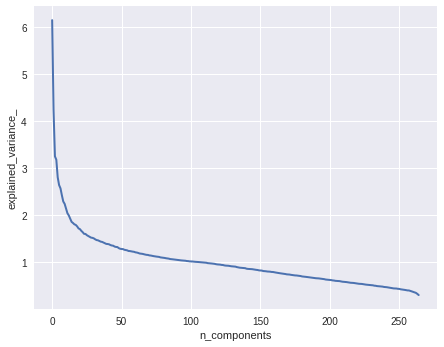

In [10]:
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca_standard_scaled.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_');

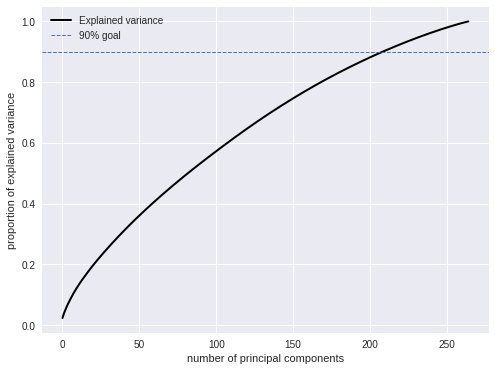

In [11]:
total_variance = np.sum(pca_standard_scaled.explained_variance_)
cum_variance = np.cumsum(pca_standard_scaled.explained_variance_)
prop_var_expl_ss = cum_variance/total_variance

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prop_var_expl_ss, color = 'black', linewidth=2, label='Explained variance')
ax.axhline(0.9, label='90% goal', linestyle='--', linewidth=1)
ax.set_ylabel('proportion of explained variance')
ax.set_xlabel('number of principal components')
ax.legend()
plt.savefig('images/pca_standard_scaler.png', 
            dpi=96, 
            format='png', 
            transparent=True);

### With a Robust Scaler

<b>Disclaimer:</b> You typically should only use a standard scaler with PCA. That didn't work so I am exploring the results from a robust scaler out of curiosity. 

In [17]:
X = df_w_rank.to_numpy()

robust_scaler = RobustScaler()
X_robust_scaled = robust_scaler.fit_transform(X)
X_robust_scaled

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
pca_robust_scaled = PCA()
X_pca_robust = pca_robust_scaled.fit_transform(X_robust_scaled)

### Selecting N-Components

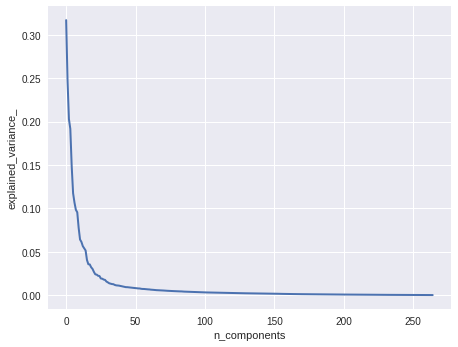

In [19]:
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca_robust_scaled.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_');

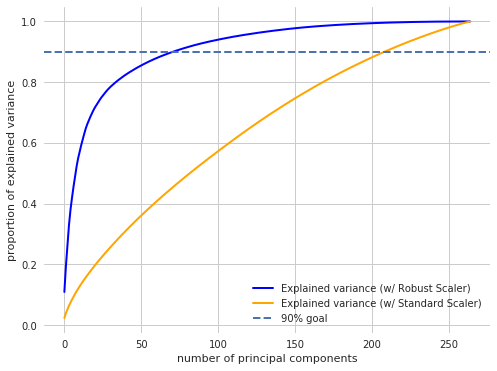

In [68]:
total_variance = np.sum(pca_robust_scaled.explained_variance_)
cum_variance = np.cumsum(pca_robust_scaled.explained_variance_)
prop_var_expl = cum_variance/total_variance

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prop_var_expl, color = 'blue', linewidth=2, label='Explained variance (w/ Robust Scaler)')
ax.plot(prop_var_expl_ss, color = 'orange', linewidth=2, label='Explained variance (w/ Standard Scaler)')
ax.axhline(0.9, label='90% goal', linestyle='--', linewidth=2)
ax.set_ylabel('proportion of explained variance')
ax.set_xlabel('number of principal components')
ax.legend()
# plt.savefig('images/pca_chart.png', 
#             dpi=96, 
#             format='png');

In [21]:
len(prop_var_expl[prop_var_expl <= 0.9])

71

In [22]:
X = df_w_rank.to_numpy()

robust_scaler = RobustScaler()
X_robust_scaled = robust_scaler.fit_transform(X)


robust_pca = PCA(n_components=71)
X_robust_pca_71pc = robust_pca.fit_transform(X_robust_scaled)

In [23]:
X = df_w_rank.to_numpy()

standard_scaler = StandardScaler()
X_standard_scaled = standard_scaler.fit_transform(X)

standard_pca = PCA(n_components=209)
X_standard_pca_209pc = standard_pca.fit_transform(X_standard_scaled)

### Exploring principal components and features

In [24]:
df_robust_pca_71pc = pd.DataFrame(X_robust_pca_71pc, 
                                index=df_w_rank.index)
df_robust_pca_71pc

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
id,,,,,,,,,,,,,,,,,,,,,
10161,0.902054,-0.308564,0.735502,0.421122,0.017534,0.030490,0.243384,0.231922,-0.359572,0.040506,...,-0.008097,0.028190,0.009215,-0.041134,-0.084151,0.112548,0.208440,0.094394,0.003020,0.439832
99726,-0.553772,0.919423,-0.563405,0.693138,0.492471,0.506488,0.254711,-0.667564,0.478517,0.084263,...,-0.083229,0.074662,-0.132921,0.171031,0.210185,0.355523,0.087165,0.446418,-0.085750,0.209953
98526,0.562031,-0.360142,0.285042,0.437012,-0.341345,-0.349306,0.202698,0.012140,-0.634208,-0.074445,...,0.121083,-0.002177,-0.062905,0.049276,0.014301,-0.085242,-0.052688,-0.028247,0.061923,-0.146267
966,-0.947915,0.433247,0.318086,-0.000632,-0.138365,-0.067705,0.449668,-0.391173,0.295402,-0.160394,...,-0.178556,0.118097,0.157297,0.430038,-0.091271,-0.117861,0.100683,0.060301,0.203083,0.230964
4876,0.893532,0.062809,-0.076532,0.672134,0.141467,-0.872544,0.062129,-0.331749,-0.450992,0.038071,...,0.103909,0.119405,0.077839,-0.135130,0.189683,-0.051602,-0.163534,0.030070,-0.087745,0.223992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99586,-0.492690,-0.461529,0.077596,0.035290,-0.218350,0.116027,0.676679,-0.626119,0.378083,-0.271106,...,-0.084429,-0.136584,0.116185,0.055282,0.047152,0.047317,-0.003047,0.101563,0.029348,-0.041335
99916,-0.610720,-0.477351,0.175739,0.605864,-0.083200,0.536619,0.216233,-1.029686,0.625074,-0.133924,...,-0.149402,-0.104113,-0.270918,0.001615,-0.126643,-0.142021,-0.054452,0.048677,-0.149893,0.078511
101283,0.072873,-0.510824,-0.055954,0.054418,-0.351963,-0.368537,-0.174322,0.523298,0.773765,0.113510,...,-0.243365,0.067193,-0.030645,-0.043301,-0.070937,0.421240,0.059783,-0.078929,0.163033,-0.318795


In [25]:
df_standard_pca_209pc = pd.DataFrame(X_standard_pca_209pc, 
                                index=df_w_rank.index)
df_standard_pca_209pc

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
id,,,,,,,,,,,,,,,,,,,,,
10161,3.063598,-1.640243,-0.071741,-2.651143,1.894873,-1.494173,-0.161998,2.115946,-4.132501,0.074186,...,-1.280429,-0.797775,-1.638379,1.843908,-0.085967,0.250175,1.001446,0.441798,-2.790720,1.421164
99726,4.010671,4.335682,-1.889051,1.029714,-1.869979,-2.469399,-5.637428,-6.284301,-8.634521,5.272465,...,1.802606,-0.326023,3.098632,-0.568971,-2.799546,0.275923,2.705581,-0.924445,0.159498,-2.380194
98526,-0.183971,-1.842167,-1.663307,-2.009235,-0.618382,-0.507958,0.020451,0.014308,-0.342828,-0.130239,...,0.380758,0.049274,0.236558,-0.671631,-0.045411,1.007387,0.236642,-0.560658,-0.722670,0.566885
966,0.115387,2.901449,0.604461,-0.227087,-1.879746,-0.007203,-0.340175,-0.356496,1.773002,1.446591,...,-0.124728,-0.588190,0.225490,0.586116,-0.619809,-0.685551,-2.091477,0.122733,-0.578945,0.135327
4876,2.242194,-2.478071,-0.000513,1.094785,-1.188318,4.357442,3.636003,-2.499282,-0.288250,0.825418,...,-0.259101,0.160440,1.877479,0.975199,0.585827,0.019913,-0.577099,0.777868,-0.484366,0.038833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99586,0.931887,5.409253,-0.435452,-2.081964,0.179776,0.901849,-0.536996,0.909874,1.867503,-0.860052,...,0.756386,-0.068006,3.364900,-0.098478,-0.370126,-0.911676,-0.482750,-1.001311,-1.453880,1.054827
99916,1.312638,5.252015,-1.833030,-2.462742,1.836728,0.337152,1.149345,0.625921,0.050251,-1.187140,...,0.274251,0.596343,-0.337935,0.450583,0.587308,-0.206677,-0.294439,0.329072,0.426225,-0.654287
101283,14.639642,-1.382140,8.207753,-2.390623,6.332417,-7.310512,0.314251,4.412330,5.207760,-0.896760,...,-4.250372,2.596445,-2.495281,-0.180468,3.551291,4.027216,-3.759761,2.362707,-1.188062,1.783288


In [26]:
sim_mat_robust_pca = cosine_similarity(df_robust_pca_71pc.values)

In [27]:
sim_mat_standard_pca = cosine_similarity(df_standard_pca_209pc.values)

In [31]:
pc_and_features_robust = pd.DataFrame(robust_pca.components_, columns=df_w_rank.columns)
pc_and_features_robust.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
0,0.551024,0.295329,-0.517596,0.071318,-0.052938,0.162764,0.029915,-0.008734,0.196966,-0.049406,...,0.000365,-0.013993,-0.000130,-0.001023,0.000188,-0.000178,0.000001,-0.002353,-0.007175,0.000731
1,0.306863,0.388868,0.716760,-0.171425,0.096076,0.278198,-0.019124,0.013853,0.010930,-0.242654,...,0.004756,0.004234,0.000140,-0.000936,0.000289,0.001020,0.000704,0.003687,0.001929,0.003099
2,0.251196,-0.334803,0.260712,0.158294,0.065612,-0.598823,-0.007525,-0.029574,0.233905,-0.070830,...,-0.008031,0.008998,0.001413,0.001271,-0.000045,0.002690,0.002162,-0.005519,0.010008,0.001131
3,0.024465,0.063969,-0.049918,0.722560,0.029649,0.229211,0.030808,0.023483,-0.084070,-0.143417,...,0.008607,0.015919,-0.000983,0.005745,0.000397,0.001645,0.006535,0.017395,0.018475,0.002666
4,-0.534272,0.563757,0.042343,0.195306,-0.111869,-0.112769,-0.073641,-0.021528,0.167961,0.003171,...,-0.005310,0.002129,-0.001127,0.000318,0.000064,-0.002210,-0.003515,-0.016341,-0.015443,-0.012880


In [32]:
# iterate through our principal components and find the features with the... 
# highest and lowest values in that principal component
for idx, vec in pc_and_features_robust.iterrows():
    vec_sorted = vec.sort_values(ascending=False)
    print('Principal Component ', idx)
    print(round(vec_sorted[(vec_sorted > 0.20) | (vec_sorted < -0.20)], 2))

    print('--------------------')

Principal Component  0
action           0.55
sci_fi           0.37
adventure        0.30
slice_of_life   -0.25
comedy          -0.52
Name: 0, dtype: float64
--------------------
Principal Component  1
comedy       0.72
adventure    0.39
action       0.31
fantasy      0.28
music       -0.24
Name: 1, dtype: float64
--------------------
Principal Component  2
sci_fi       0.48
comedy       0.26
action       0.25
mecha        0.23
adventure   -0.33
fantasy     -0.60
Name: 2, dtype: float64
--------------------
Principal Component  3
drama      0.72
romance    0.47
fantasy    0.23
Name: 3, dtype: float64
--------------------
Principal Component  4
adventure       0.56
sci_fi          0.38
supernatural   -0.30
action         -0.53
Name: 4, dtype: float64
--------------------
Principal Component  5
fantasy         0.50
romance         0.39
sci_fi          0.36
drama          -0.25
supernatural   -0.25
adventure      -0.35
Name: 5, dtype: float64
--------------------
Principal Component  6
sli

Name: 65, dtype: float64
--------------------
Principal Component  66
philosophy          0.40
virtual_world       0.26
anti_hero           0.26
super_robot         0.22
yuri               -0.21
card_battle        -0.23
post_apocalyptic   -0.27
Name: 66, dtype: float64
--------------------
Principal Component  67
vampire        0.38
gore           0.25
super_robot   -0.24
amnesia       -0.30
politics      -0.33
Name: 67, dtype: float64
--------------------
Principal Component  68
video_games             0.27
gore                    0.23
gods                    0.22
virtual_world           0.20
guns                    0.20
nudity                 -0.21
primarily_child_cast   -0.23
revenge                -0.25
vampire                -0.33
Name: 68, dtype: float64
--------------------
Principal Component  69
family_life     0.33
martial_arts    0.30
amnesia         0.23
philosophy      0.21
politics       -0.28
full_cgi       -0.40
Name: 69, dtype: float64
--------------------
Principal Co

In [33]:
pp = pprint.PrettyPrinter()
# getting the top titles associated with the first principal components
cut_off = 5
top_n_comps = 50
print(f'Here are the first {top_n_comps} principal components with shows that are good examples and genre/tags that are most common.')
print('--------')
for pc, content in df_robust_pca_71pc.iloc[:,:top_n_comps].items():
    print(f'Principal Component {pc}:')
    top_n_ids = content.sort_values(ascending=False)[:cut_off].index
    pp.pprint([get_title_from_id(_id) for _id in top_n_ids])
    print('-----')

Here are the first 50 principal components with shows that are good examples and genre/tags that are most common.
--------
Principal Component 0:
['Mobile Suit Gundam Wing',
 'Napping Princess',
 'Melody of Oblivion',
 'Mobile Suit Gundam I',
 "Dragon's Heaven"]
-----
Principal Component 1:
['The Seven Deadly Sins',
 'The Familiar of Zero',
 'Dragon Ball Z Movie: Battle of Gods',
 'Fairy Tail Final Season',
 "Dragon Ball Z Movie: Resurrection 'F'"]
-----
Principal Component 2:
['Gurren Lagann',
 'DARLING in the FRANXX',
 'Infinite Stratos',
 'Infinite Stratos 2',
 'Gunbuster']
-----
Principal Component 3:
['Revolutionary Girl Utena',
 "Beyond the Boundary -I'LL BE HERE-: Future",
 'Sugar Sugar Rune',
 'Spirited Away',
 'Clannad']
-----
Principal Component 4:
['Mobile Suit Gundam 0083: Stardust Memory',
 'Brigadoon: Marin to Melan',
 'Eureka Seven',
 'Mobile Suit Gundam: The 08th MS Team',
 'Galaxy Express 999']
-----
Principal Component 5:
['Magical Angel Creamy Mami',
 'Genius Party',

In [ ]:
pc_and_features_standard = pd.DataFrame(standard_pca.components_, columns=df_w_rank.columns)
pc_and_features_standard.head()

In [ ]:
for idx, vec in pc_and_features_standard.iterrows():
    vec_sorted = vec.sort_values(ascending=False)
    print('Principal Component ', idx)
    print(round(vec_sorted[(vec_sorted > 0.10) | (vec_sorted < -0.10)], 2))

    print('--------------------')

In [ ]:
pp = pprint.PrettyPrinter()
# getting the top titles associated with the first principal components
cut_off = 10
top_n_comps = 50
# print(f'Here are the first {top_n_comps} principal components with shows that are good examples and genre/tags that are most common.')
print('--------')
for pc, content in df_standard_pca_209pc.iloc[:,:top_n_comps].items():
    print(f'Principal Component {pc}:')
    top_n_ids = content.sort_values(ascending=False)[:cut_off].index
    pp.pprint([get_title_from_id(_id) for _id in top_n_ids])
    print('-----')

In [ ]:
search_term = get_search_term('Cowboy Bebop')
id_list = get_anime_id(search_term)
rs_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_robust_pca_71pc, 
                                     sim_mat_robust_pca, 
                                     n=10)
ss_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_standard_pca_209pc, 
                                     sim_mat_standard_pca, 
                                     n=10)
print('Robust scaler')
pp.pprint(rs_pca_rec_list)
print('-----')
print('Standard scaler')
pp.pprint(ss_pca_rec_list)

In [ ]:
search_term = get_search_term('Dragonball Z')
id_list = get_anime_id(search_term)
rs_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_robust_pca_71pc, 
                                     sim_mat_robust_pca, 
                                     n=10)
ss_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_standard_pca_209pc, 
                                     sim_mat_standard_pca, 
                                     n=10)
print('Robust scaler')
pp.pprint(rs_pca_rec_list)
print('-----')
print('Standard scaler')
pp.pprint(ss_pca_rec_list)

In [ ]:
search_term = get_search_term('Attack on Titan')
id_list = get_anime_id(search_term)
rs_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_robust_pca_71pc, 
                                     sim_mat_robust_pca, 
                                     n=10)
ss_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_standard_pca_209pc, 
                                     sim_mat_standard_pca, 
                                     n=10)
print('Robust scaler')
pp.pprint(rs_pca_rec_list)
print('-----')
print('Standard scaler')
pp.pprint(ss_pca_rec_list)

The standard scaler does a better job at giving a range of recommended titles but it feels like it sometimes it misses the mark. (I'm surprised a Shin-chan movie was recommended based on "Attack on Titan")  
Also, the robust scaler enabled PCA to get down to a lot less principal components than the standard scaler. 

## NMF

In [34]:
M = df_w_rank
M

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99586,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
99916,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0
101283,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [37]:
nmf = NMF(n_components=20)
nmf.fit(M)
W = nmf.transform(M)
H = nmf.components_
nmf.reconstruction_err_

92.57869759206909

In [38]:
W.shape

(9832, 20)

In [39]:
H.shape

(20, 265)

Text(0, 0.5, 'Reconstruction Errror')

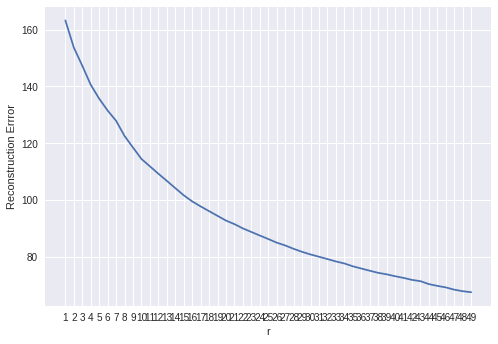

In [64]:
def fit_nmf(r):
    '''Fit an nmf model using one component up to r components
    See which has the optimal reconstruction error'''
    nmf = NMF(n_components=r, 
              init='nndsvd', 
              alpha=1)
    nmf.fit(M)
    W = nmf.transform(M)
    H = nmf.components_
    return nmf.reconstruction_err_

_range = 50
error = [fit_nmf(i) for i in range(1,_range)]
plt.plot(range(1,_range), error)
plt.xticks(range(1, _range))
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

In [58]:
# reconstruction error for 20 compenents
fit_nmf(5)

135.69731415870103

In [59]:
nmf = NMF(n_components=5)
nmf.fit(M)
W = nmf.transform(M)
H = nmf.components_

In [60]:
df_topics_to_item = pd.DataFrame(W, index=df_w_rank.index)
df_topics_to_item

,0,1,2,3,4
id,,,,,
10161,0.103518,0.000000,0.112778,0.000000,0.141118
99726,0.000000,0.178921,0.091937,0.189255,0.000000
98526,0.108774,0.000000,0.105961,0.000000,0.010721
966,0.015631,0.211997,0.029994,0.008351,0.000000
4876,0.120358,0.000000,0.124659,0.091385,0.013479
...,...,...,...,...,...
99586,0.009243,0.060369,0.056737,0.001664,0.000000
99916,0.000000,0.050125,0.133010,0.000170,0.000000
101283,0.034427,0.000000,0.051073,0.001629,0.006783


In [61]:
df_topics_to_features = pd.DataFrame(H, columns=df_w_rank.columns)
df_topics_to_features

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
0,7.828665,0.000000,0.000000,0.000000,0.405324,0.000000,0.477857,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.012065,0.000000,0.002139,0.019729,0.018040,0.030689,0.063721,0.063714
1,0.000000,0.000000,6.255207,0.000000,0.773687,0.000000,0.000000,0.118290,0.00000,0.071299,...,0.009952,0.106154,0.007460,0.000000,0.000165,0.011288,0.005445,0.020143,0.078813,0.016942
2,0.000000,0.000000,0.000000,5.501573,0.040562,0.033419,0.266495,0.126747,0.00000,0.659891,...,0.030541,0.118974,0.000000,0.039256,0.001745,0.011702,0.041170,0.088360,0.142097,0.004802
3,0.000000,4.990851,0.157519,0.000000,0.000000,5.287924,0.011409,0.258514,0.00000,0.000000,...,0.073248,0.000000,0.000000,0.000000,0.001460,0.000000,0.000000,0.039027,0.000000,0.000000
4,0.316450,1.030846,0.003751,0.235270,0.000000,0.000000,0.000000,0.000000,2.70107,0.093634,...,0.000000,0.000000,0.000262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [62]:
for topic in df_topics_to_item.items():
    print('Topic ', topic[0])
    for _id in list(topic[1].sort_values(ascending=False)[:5].index):
        print(get_title_from_id(_id))
    print('-----')

Topic  0
The Future Diary
JoJo's Bizarre Adventure
the Garden of sinners Chapter 1: Thanatos. (Overlooking View)
Yu Yu Hakusho: Ghostfiles
JoJo's Bizarre Adventure: Stardust Crusaders
-----
Topic  1
We Never Learn: BOKUBEN
Haganai
My First Girlfriend is a Gal
Saekano: How to Raise a Boring Girlfriend
Gabriel DropOut
-----
Topic  2
Bloom Into You
Your Lie in April
Revolutionary Girl Utena
Kids on the Slope
Rewrite
-----
Topic  3
That Time I Got Reincarnated as a Slime
Fairy Tail
Fairy Tail (2014)
Fairy Tail Final Season
InuYasha
-----
Topic  4
Metal Armor Dragonar
Mobile Suit Gundam Wing
Macross II: Lovers Again
Mobile Suit Gundam I
Galaxy Fraulein Yuna Returns
-----


In [63]:
for topic in df_topics_to_features.iterrows():
    print('Topic', topic[0])
    print(topic[1].sort_values(ascending=False)[:5])
    print('-----')

Topic 0
action              7.828665
supernatural        1.458639
shounen             1.048079
super_power         1.017760
male_protagonist    0.946156
Name: 0, dtype: float64
-----
Topic 1
comedy           6.255207
slice_of_life    1.118370
school           0.777948
ecchi            0.773687
romance          0.680105
Name: 1, dtype: float64
-----
Topic 2
drama                 5.501573
romance               3.148058
slice_of_life         1.607286
school                0.878110
female_protagonist    0.769573
Name: 2, dtype: float64
-----
Topic 3
fantasy      5.287924
adventure    4.990851
magic        0.925449
shounen      0.528526
kids         0.439837
Name: 3, dtype: float64
-----
Topic 4
sci_fi       5.624722
mecha        2.701070
adventure    1.030846
space        0.660769
military     0.527382
Name: 4, dtype: float64
-----


In [ ]:
M.head()

In [ ]:
df_topics_to_item.head()

## Comparing Everything

In [ ]:
nmf = NMF(n_components=50)
nmf.fit(M)
W = nmf.transform(M)
H = nmf.components_

In [ ]:
X = df_w_rank.to_numpy()

standard_scaler = StandardScaler()
X_standard_scaled = standard_scaler.fit_transform(X)

standard_pca = PCA(n_components=50)
X_standard_pca_50pc = standard_pca.fit_transform(X_standard_scaled)

In [ ]:
df_standard_pca_50pc = pd.DataFrame(X_standard_pca_50pc, 
                                index=df_w_rank.index)

In [ ]:
sim_mat_standard_pca_50pc = cosine_similarity(X_standard_pca_50pc)

In [ ]:
sim_mat_nmf_50comps = cosine_similarity(W)

In [ ]:
df_w_rank

In [ ]:
cos_sim_no_reduc = cosine_similarity(df_w_rank.values)

In [ ]:
sim_mat_standard_pca_209pc = cosine_similarity(df_standard_pca_209pc.values)

In [ ]:
def compare_dim_reducs(anime_title):
    search_term = get_search_term(anime_title)
    id_list = get_anime_id(search_term)
    nmf_rec_list = get_top_n_recommendations(id_list, 
                                         pd.DataFrame(W, index=df_w_rank.index), 
                                         sim_mat_nmf_50comps, 
                                         n=10)
    ss_pca_rec_list = get_top_n_recommendations(id_list, 
                                         df_standard_pca_50pc, 
                                         sim_mat_standard_pca_50pc, 
                                         n=10)
    ss_pca_209pc_rec_list = get_top_n_recommendations(id_list, 
                                         df_standard_pca_209pc, 
                                         sim_mat_standard_pca_209pc, 
                                         n=10)
    rs_pca_rec_list = get_top_n_recommendations(id_list, 
                                         df_robust_pca_71pc, 
                                         sim_mat_robust_pca, 
                                         n=10)
    basic_rec_list = get_top_n_recommendations(id_list, 
                                         df_w_rank, 
                                         cos_sim_no_reduc, 
                                         n=10)
    print('NMF w/ 50 components')
    pp.pprint(nmf_rec_list)
    print('-----')
    print('PCA w/ 50 PCs')
    pp.pprint(ss_pca_rec_list)
    print('-----')
    print('PCA w/ 209 PCs')
    pp.pprint(ss_pca_209pc_rec_list)
    print('-----')
    print('PCA w/ a Robust Scaler and 71 PCs')
    pp.pprint(rs_pca_rec_list)
    print('-----')
    print('No Dimensionality Reduction')
    pp.pprint(basic_rec_list)

In [ ]:
compare_dim_reducs('Dragonball Z')

In [ ]:
compare_dim_reducs('Ergo Proxy')

In [ ]:
compare_dim_reducs('Gangsta')

In [ ]:
compare_dim_reducs('Tokyo Ghoul')

In [ ]:
compare_dim_reducs('Food Wars!')

In [ ]:
compare_dim_reducs('One Punch Man')

<b> Choosing whether to use dimensionality reduction, and then choosing the best technique is proving difficult. The results from all are subjective and usually very similar. Using PCA w/ 209 principal components might be in the lead because it usually is able to provide a variety of recommendations (but sometimes it fails). And if I'm only cutting down my dimensions by 20%, then is it really worth it?  </b>

<b>After further thought, maybe no dimensionality reduction is the way to go for now. A loss in computation speed is not a big deal for this application at this point. It's more valuable to give more accurate recommendations. </b>